# Experiment Configuration and Execution

In this tutorial we show how to configure and execute an experiment in OpenSBT to test an Agent. We show the configuration of the experiment for testing a simplistic agent in a simplified simulator (no GPU required).

_Note: This example is for introducing OpenSBT. An application with a high fidelity simulation and *real* SUT is provided [here](doc/jupyter/06_Example_CARLA.ipynb)._

## Dummy Example

We refer to this example as Dummy Example. The example contains an AEB agent and a pedestrian. Both actors move linear, while the pedestrian has a fixed trajectory and fixed velocity, the ego agent has a predefined path but can modify his velocity. That means, ego brakes when he detects other actors within a predefined distance. We want to test the AEB agent in violating the safety distance of 1m. For this we want to vary the initial velocities of both actors as well the orientation of the pedestrian crossing egos' lane.

In particlar, the pedestrian has a speed in the range of [0.2, 3] m/s, the ego [1, 10] m/s, while the orientation range is [0,180] degrees.

## Defining An Experiment

To define an experiment we need to instantiate `ADASProblem`. `ADASProblem` holds:

- the **scenario**, which can be e.g., an OpenSCENARIO file, or file of another format supported by simulator,
- the **search variables**, whose values are altered to produce (different) scenarios througout the search,
- the **search space**, represented by the lower and upper bounds as arrays,
- the **fitness function**, 
- the **criticality function**, which represents the safety requirements/testing oracle,
- the **simulate function** to trigger the simulator via this function,
- the **simulator-related variables**, i.e., simulation time, sampling time, toggle for visualization.

_Note, that for now the SUT is triggered via the Simulater Interface, as we assume that the SUT is embedded into the simulator. We are working on an update where the SUT can be defined uncoupled from the simulator._

In [2]:
cd opensbt-core

/home/sorokin/Projects/testing/search-based-test-case-generation/doc/jupyter/opensbt-core


In [13]:
from evaluation.fitness import FitnessMinDistanceVelocity
from problem.adas_problem import ADASProblem
from problem.pymoo_test_problem import PymooTestProblem
from evaluation.critical import CriticalAdasDistanceVelocity
from simulation.dummy_simulation import DummySimulator


problem = ADASProblem(
                      problem_name="DummySimulatorProblem",
                      scenario_path="scenarios/dummy_scenario.xosc",
                      xl=[0, 1, 0, 0],
                      xu=[180, 10,180, 2],
                      simulation_variables=[
                          "orientation_ego",
                          "velocity_ego",
                          "orientation_ped",
                          "velocity_ped"],
                      fitness_function=FitnessMinDistanceVelocity(),
                      critical_function=CriticalAdasDistanceVelocity(),
                      simulate_function=DummySimulator.simulate,
                      simulation_time=10,
                      sampling_time=0.25
                      )

We have two options to execute the testing experiment: using the console or using the code directly. 

## Experiment Execution (Code)

To start search without console, we instantiate the search algorithms `Optimizer` and call its `run` method to start the search. When the search has finished, we write the results by calling an output method (line 9). The results will be written in the default folder name `results`, if no folder name is passed.

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      3 |             - |             -
     2 |       40 |      7 |  0.0048833833 |         ideal
     3 |       60 |      8 |  0.0297266850 |         ideal
     4 |       80 |      7 |  0.1151720326 |         ideal
     5 |      100 |     10 |  0.0455144670 |             f
[None None None None None None None None None None]


AttributeError: 'NoneType' object has no attribute 'otherParams'

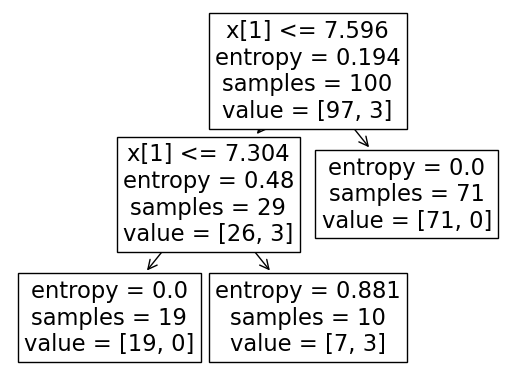

In [14]:
import pymoo

from model_ga.individual import IndividualSimulated
pymoo.core.individual.Individual = IndividualSimulated

from model_ga.population import PopulationExtended
pymoo.core.population.Population = PopulationExtended

from model_ga.result  import SimulationResult
pymoo.core.result.Result = SimulationResult

from model_ga.problem import SimulationProblem
pymoo.core.problem.Problem = SimulationProblem

from algorithm.nsga2_optimizer import NsgaIIOptimizer

# Instantiate search algorithm
optimizer = NsgaIIOptimizer(
                            problem=problem,
                            config=DefaultSearchConfiguration()
                            )
# Run search
res = optimizer.run()

# Write results
res.write_results(params = optimizer.parameters)

## Experiment Execution (Console)

To start the search through the console we need to create an `Experiment` instance. The experiment instance receives following inputs:

- the experiment name (type `str`)
- the created problem (type `ADASProblem`) 
- the search algorithm (type `AlgorithmType`)
- the search configuration (type `SearchConfiguration`)

Note, that the algorithm that is passed is an enumeration value which need to be registed beforehand via the `algorithm.py` script.

In [5]:
experiment = Experiment(name="6",
                        problem=problem,
                        algorithm=AlgorithmType.NSGAII,
                        search_configuration=DefaultSearchConfiguration())

Then we register the experiment so that we can use it later via console.

In [10]:
from experiment.experiment_store import experiments_store
experiments_store.register(experiment)

1

To start search via console we run the experiment with the name "6":

In [11]:
!python run.py -e 6

2023-10-18 03:26:31,002 INFO     Logging setup. Writing to file:  ./log.txt
2023-10-18 03:26:31,003 INFO     Selected experiment: 6
2023-10-18 03:26:31,003 INFO     Experiment with the given name does not exist.
Traceback (most recent call last):
  File "run.py", line 101, in <module>
    config = experiment.search_configuration
AttributeError: 'int' object has no attribute 'search_configuration'


We can change the experiment parameters, such e.g., lower and upper bounds of the search parameters, the search time, iteration size or population size by using flags:

In [22]:
!python run.py -e 6 -min 3 3 -max 4 4 -m  "velocity_ego" "velocity_ego" -i 50

2023-10-15 23:42:03,969 INFO     Logging setup. Writing to file:  ./log.txt
2023-10-15 23:42:03,970 INFO     Selected experiment: 6
2023-10-15 23:42:03,970 INFO     Experiment with the given name does not exist.
Traceback (most recent call last):
  File "run.py", line 101, in <module>
    config = experiment.search_configuration
AttributeError: 'int' object has no attribute 'search_configuration'


## Flags

The complete list of flags is provided below.

```
 -h, --help            show this help message and exit
  -e EXP_NUMBER         Name of existing experiment to be used. (show all experiments via -info)].
  -i N_GENERATIONS      Number generations to perform.
  -n SIZE_POPULATION    The size of the initial population of scenario candidates.
  -a ALGORITHM          The algorithm to use for search. (Currently only 1: NSGAII supported.)
  -t MAXIMAL_EXECUTION_TIME
                        The time to use for search.
  -f SCENARIO_PATH      The path to the scenario description file.
  -min VAR_MIN [VAR_MIN ...]
                        The lower bound of each search parameter.
  -max VAR_MAX [VAR_MAX ...]
                        The upper bound of each search parameter.
  -m DESIGN_NAMES [DESIGN_NAMES ...]
                        The names of the variables to modify.
  -o RESULTS_FOLDER     The name of the folder where the results of the search are stored (default: /results/single/)
  -v                    Whether to use the simuator's visualization. This feature is useful for debugging and demonstrations, however it reduces the search performance.
  -info                 Names of all defined experiments.
```
